# Выборка и агрегация данных в MongoDB

###Цель домашней работы

Закрепить на практике основные приемы работы с СУБД MongoDB, включая выборку, сортировку, объединение, агрегацию данных и передачу результатов выборки в программу на Python в целях аналитики и дальнейшей обработки.

### Условия выполнения задания

В этом задании вам предстоит выполнить несколько запросов к базе данных для получения выборок по условиям, а также воспользоваться фреймворком агрегации MongoDB для построения конвейера обработки данных.

**Максимальное количество баллов за выполнение домашней работы:** 10.

##Как выполнять задание

В работе над заданием нужно использовать следующие инструменты:

* **MongoDB:**

1. Зарегистрируйтесь в сервисе MongoDB Atlas: https://www.mongodb.com/atlas/database.
1. Создайте кластер уровня M0 — это бесплатно.
1. Добавьте в кластер тестовую базу данных `sample_mflix`, используя опцию Load Sample Dataset.

В качестве альтернативы вы можете установить MongoDB на свой локальный компьютер и импортировать необходимые датасеты в свою СУБД, загрузив их по ссылке: https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix. Для этого подключитесь к своему серверу через Compass, создайте новую БД, создайте для каждого датасета коллекцию и щелкните Add data → Import JSON or CSV file.

* **MongoDB Compass** — графический интерфейс для работы с MongoDB, который можно использовать как вспомогательный инструмент при создании запросов и построении агрегаций.

* **Python и библиотека PyMongo.** Работайте в Jupyter Notebook или Google Colaboratory. Рекомендуется использовать версию Python 3.12.

##Формат сдачи

Результаты работы необходимо оформить в виде ноутбука Jupyter. Можно загрузить файл в LMS либо поделиться ссылкой на Google Colaboratory.

##Место, где нужно выполнить задание



In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
print(client.list_database_names())  # Вывести список БД для проверки подключения

# Инициализация подключения к базе данных
db = client["sample_mflix"]
theaters = db["theaters"]
comments = db["comments"]
movies = db["movies"]

['admin', 'config', 'local', 'sample_mflix']


In [2]:
import pandas as pd
from IPython.display import display

def flatten_dict(d, parent_key='', sep='.'):
    """Flatten nested dictionary structure.
    
    Recursively flattens nested dictionaries by joining keys with separator.
    Lists of dictionaries are converted to string representation.
    
    Args:
        d (dict): Dictionary to flatten.
        parent_key (str, optional): Parent key prefix for nested keys. Defaults to ''.
        sep (str, optional): Separator for joined keys. Defaults to '.'.
    
    Returns:
        dict: Flattened dictionary with dot-notation keys.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict):
            # Handle lists of dicts by converting to string representation
            items.append((new_key, str(v)))
        else:
            items.append((new_key, v))
    return dict(items)

def query_and_print(collection, query, projection=None):
    """Query MongoDB collection and display results as a DataFrame.
    
    Executes a MongoDB query and displays the results in a formatted DataFrame.
    Nested dictionaries are automatically flattened for better readability.
    
    Args:
        collection (pymongo.collection.Collection): MongoDB collection to query.
        query (dict): MongoDB query filter.
        projection (dict, optional): MongoDB projection to limit returned fields.
            Example: {"title": 1, "year": 1, "_id": 0}. Defaults to None.
    
    Returns:
        None: Displays results directly. Returns None if no results found.
    """
    if projection is not None:
        result = collection.find(query, projection)
    else:
        result = collection.find(query)
    
    data = list(result)
    if not data:
        print("No results found")
        return
    
    # Flatten nested dictionaries
    flattened_data = [flatten_dict(doc) for doc in data]
    df = pd.DataFrame(flattened_data)
    display(df)

### Упражнение 1. Запросы на выборку

Цель этого упражнения — закрепить навык выполнения запросов на выборку. Все запросы выполняются на базе `sample_mflix` с данными о кинофильмах.

#### Задача 1.1 (1 балл)

Выведите из коллекции `theaters` документы о кинотеатрах в городе Florence, штат KY.

**Для справки:**

* Обратите внимание, что информация об адресе кинотеатров хранится во вложенных документах. Для доступа к полям вложенных документов следует использовать точку: `родительский_документ.вложенный_документ.поле`.
* В случае затруднений с написанием логического условия обращайтесь к сопоставлению синтаксиса SQL и Mongo: https://www.mongodb.com/docs/manual/reference/sql-comparison/.
* Если вы предпочитаете сперва выполнять запросы в Compass, из этого приложения можно выгружать код готового запроса на Python (кнопка с символом `</>`).

In [3]:
query = {
    "location.address.city": "Florence",
    "location.address.state": "KY"
}

query_and_print(theaters, query)


,_id,theaterId,location.address.street1,location.address.city,location.address.state,location.address.zipcode,location.geo.type,location.geo.coordinates,location.address.street2
0,59a47287cfa9a3a73e51e893,161,100 Meijer Dr.,Florence,KY,41042,Point,"[-84.636383, 39.014843]",NaN
1,59a47287cfa9a3a73e51ea02,2823,2823 Florence Mall,Florence,KY,41042,Point,"[-84.6499595, 38.9967246]",#2148


#### Задача 1.2 (1 балл)

Сделайте запрос к коллекции `comments` и выведите один комментарий (значение поля `text`) пользователя по имени Doreah.

In [4]:
comment = comments.find_one({"name": "Doreah"})
print(comment["text"])


Porro explicabo cumque vitae sint quia quis. Consequuntur voluptatibus optio maxime ratione temporibus incidunt minus architecto.


#### Задача 1.3 (1 балл)

Сделайте запрос к коллекции `movies` и выведите количество документов, в которых в качестве первого жанра фильма (поле `genres`) указано значение Horror.

**Для справки:**

1. Обратите внимание, что поле `genres` представляет собой массив (индексация массивов начинается с нуля).
1. При работе в MongoDB Shell для подсчета количества документов в курсоре можно использовать метод `count()`, однако он был удален в последних версиях библиотеки PyMongo. В случае затруднений с использованием функций Mongo можно использовать для подсчета документов средства Python.

In [5]:
count = movies.count_documents({"genres.0": "Horror"})
print(f"Количество фильмов с первым жанром Horror: {count}")


Количество фильмов с первым жанром Horror: 814


#### Задача 1.4 (2 балла)

Выведите из коллекции `movies` документы о фильмах, которые в качестве первого жанра определены как Film-Noir либо Horror и были выпущены в период с 1940 по 1949 г. (включительно).

In [6]:
query = {
    "genres.0": {"$in": ["Film-Noir", "Horror"]},
    "year": {"$gte": 1940, "$lte": 1949}
}

query_and_print(movies, query)


,_id,plot,genres,runtime,rated,cast,poster,title,fullplot,languages,...,tomatoes.lastUpdated,tomatoes.consensus,tomatoes.rotten,tomatoes.production,tomatoes.fresh,num_mflix_comments,tomatoes.viewer.meter,tomatoes.dvd,tomatoes.website,tomatoes.boxOffice
0,573a1393f29313caabcdc814,An American man marries a Serbian immigrant wh...,"[Horror, Thriller]",73,APPROVED,"[Simone Simon, Kent Smith, Tom Conway, Jane Ra...",https://m.media-amazon.com/images/M/MV5BNzI4YW...,Cat People,"Irena Dubrovna, a beautiful and mysterious Ser...","[English, Czech, Serbian]",...,2015-09-15 17:03:25,Influential noir director Jacques Tourneau inf...,3.0,RKO Pictures,37.0,NaN,NaN,NaT,NaN,NaN
1,573a1393f29313caabcdcdf5,A seemingly tame leopard used for a publicity ...,"[Horror, Thriller]",66,APPROVED,"[Dennis O'Keefe, Margo, Jean Brooks, Isabel Je...",https://m.media-amazon.com/images/M/MV5BYmU4ZD...,The Leopard Man,"At the encouragement of her manager, a nightcl...","[English, Spanish]",...,2015-08-27 18:06:02,NaN,2.0,NaN,15.0,1.0,67.0,NaT,NaN,NaN
2,573a1393f29313caabcdd38c,A ruthless doctor and his young prize student ...,"[Horror, Thriller]",77,APPROVED,"[Boris Karloff, Bela Lugosi, Henry Daniell, Ed...",https://m.media-amazon.com/images/M/MV5BNzNmOT...,The Body Snatcher,"In Edinburgh in 1831, Dr. Wolfe MacFarlane run...",[English],...,2015-08-21 19:11:47,NaN,3.0,RKO Pictures,13.0,1.0,75.0,NaT,NaN,NaN
3,573a1393f29313caabcdd3ed,An architect senses impending doom as his half...,[Horror],77,APPROVED,"[Mervyn Johns, Roland Culver, Mary Merrall, Go...",https://m.media-amazon.com/images/M/MV5BYTY2OT...,Dead of Night,"Architect Walter Craig, seeking the possibilit...","[English, French]",...,2015-07-26 18:40:43,"With four accomplished directors contributing,...",1.0,Universal Pictures,26.0,1.0,88.0,2009-01-27,NaN,NaN
4,573a1393f29313caabcdd5bc,A psychiatrist protects the identity of an amn...,"[Film-Noir, Mystery, Romance]",111,UNRATED,"[Ingrid Bergman, Gregory Peck, Michael Chekhov...",https://m.media-amazon.com/images/M/MV5BMTM2ND...,Spellbound,The head of the Green Manors mental asylum Dr....,[English],...,2015-08-23 19:19:48,NaN,6.0,Twentieth Century Fox Home Entertainment,29.0,2.0,83.0,2001-03-13,NaN,NaN
5,573a1393f29313caabcdd6e7,Chuck Scott gets a job as chauffeur to tough g...,[Film-Noir],86,APPROVED,"[Robert Cummings, Michèle Morgan, Steve Cochra...",https://m.media-amazon.com/images/M/MV5BNDI3OT...,The Chase,Returning a lost wallet gains unemployed veter...,"[English, Spanish]",...,2015-08-20 18:14:48,NaN,NaN,VCI,NaN,1.0,40.0,2003-08-05,NaN,NaN
6,573a1393f29313caabcdcd9d,A young Canadian nurse (Betsy) comes to the We...,[Horror],69,APPROVED,"[James Ellison, Frances Dee, Tom Conway, Edith...",https://m.media-amazon.com/images/M/MV5BZjQzMz...,I Walked with a Zombie,A young Canadian nurse (Betsy) comes to the We...,[English],...,2015-08-26 18:16:16,Evocative direction by Jacques Tourneur collid...,2.0,Warner Home Video,24.0,1.0,75.0,2005-10-04,NaN,NaN
7,573a1393f29313caabcde4cb,Pulp novelist Holly Martins travels to shadowy...,"[Film-Noir, Mystery, Thriller]",93,NOT RATED,"[Joseph Cotten, Alida Valli, Orson Welles, Tre...",https://m.media-amazon.com/images/M/MV5BYjE2OT...,The Third Man,"An out of work pulp fiction novelist, Holly Ma...","[English, German, Russian]",...,2015-09-17 17:25:35,This atmospheric thriller is one of the undisp...,0.0,Rialto Pictures,76.0,NaN,94.0,1999-11-30,http://www.rialtopictures.com/thirdman,$0.4M
8,573a1393f29313caabcde460,Over-the-hill boxer Bill 'Stoker' Thompson ins...,"[Film-Noir, Sport]",73,APPROVED,"[Robert Ryan, Audrey Totter, George Tobias, Al...",https://m.media-amazon.com/images/M/MV5BMjEwNj...,The Set-Up,Over-the-hill boxer Bill 'Stoker' Thompson ins...,[English],...,2015-07-26 18:33:52,NaN,1.0,NaN,6.0,1.0,88.0,2004-07-06,NaN,NaN


#### Задача 1.5 (1 балл)

Модифицируйте запрос из задачи 1.4 таким образом, чтобы осуществить **проекцию**: результатом выборки должен стать список словарей, каждый из которых содержит только два поля: `title` и `year`.

Для справки о проекции смотрите документацию по методу `find()` в PyMongo:
https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.find

In [7]:
query = {
    "genres.0": {"$in": ["Film-Noir", "Horror"]},
    "year": {"$gte": 1940, "$lte": 1949}
}

projection = {
    "title": 1,
    "year": 1,
    "_id": 0
}

query_and_print(movies, query, projection)


,title,year
0,Cat People,1942
1,The Leopard Man,1943
2,The Body Snatcher,1945
3,Dead of Night,1945
4,Spellbound,1945
5,The Chase,1946
6,I Walked with a Zombie,1943
7,The Third Man,1949
8,The Set-Up,1949


### Упражнение 2. Агрегация с помощью конвейеров

#### Задача 2.1 (3 балла)

В этой задаче вам требуется определить, какие фильмы получили наибольшее количество комментариев. Составьте для этого конвейер агрегации с перечисленными ниже этапами. Для удобства рекомендуется воспользоваться приложением Compass.

**Этапы выполнения задания:**

1. Сгруппировать документы коллекции `comments` по полю `movie_id` и подсчитать количество комментариев для каждого фильма, записав его в поле `count`.
1. Отсортировать получившийся набор данных по убыванию количества комментариев (так, чтобы первый документ в этом наборе указывал на фильм с наибольшим количеством комментариев).
1. Используя оператор `$lookup`, присоединить коллекцию `movies` (по полю `movie_id`).
1. Выполнить проекцию, оставив в наборе данных только три поля: название фильма (`title`), год выпуска (`year`) и количество комментариев (поле `count`, добавленное на первом этапе). Для этого воспользуйтесь оператором `$project`: https://www.mongodb.com/docs/manual/reference/operator/aggregation/project/. Обратите внимание, что данные из коллекции `movies` (`title` и `year`) на этом этапе окажутся внутри массива.
1. Применить оператор `$unwind`, чтобы деконструировать этот массив (подробнее на https://www.mongodb.com/docs/manual/reference/operator/aggregation/unwind/). В результате массив должен превратиться в одиночный объект.
1. Применить оператор `$addFields`, чтобы добавить поля `title` и `year` на верхний уровень структуры документа (https://www.mongodb.com/docs/manual/reference/operator/aggregation/addFields/).
1. Выполнить проекцию еще раз, чтобы удалить поле с массивом.

Ваш алгоритм решения может отличаться от приведенного здесь. Главное — достичь цели: **получить плоский набор данных с тремя полями** (`count` — количество комментариев, `year` — год выпуска, `title` — название фильма).

Скопируйте полученный конвейер в этот документ в виде кода на Python и выведите его на экран в виде списка словарей.

In [8]:
pipeline = [
    {
        "$group": {
            "_id": "$movie_id",
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"count": -1}
    },
    {
        "$lookup": {
            "from": "movies",
            "localField": "_id",
            "foreignField": "_id",
            "as": "movie_info"
        }
    },
    {
        "$project": {
            "count": 1,
            "movie_info.title": 1,
            "movie_info.year": 1
        }
    },
    {
        "$unwind": "$movie_info"
    },
    {
        "$addFields": {
            "title": "$movie_info.title",
            "year": "$movie_info.year"
        }
    },
    {
        "$project": {
            "_id": 0,
            "count": 1,
            "title": 1,
            "year": 1
        }
    }
]

result = list(comments.aggregate(pipeline))
for doc in result:
    print(doc)


{'count': 161, 'title': 'The Taking of Pelham 1 2 3', 'year': 2009}
{'count': 158, 'title': '50 First Dates', 'year': 2004}
{'count': 158, 'title': "Ocean's Eleven", 'year': 2001}
{'count': 158, 'title': 'About a Boy', 'year': 2002}
{'count': 158, 'title': 'Terminator Salvation', 'year': 2009}
{'count': 157, 'title': 'Sherlock Holmes', 'year': 2009}
{'count': 157, 'title': 'The Mummy', 'year': 1999}
{'count': 155, 'title': 'Hellboy II: The Golden Army', 'year': 2008}
{'count': 154, 'title': 'Anchorman: The Legend of Ron Burgundy', 'year': 2004}
{'count': 154, 'title': 'The Mummy Returns', 'year': 2001}
{'count': 153, 'title': 'E.T. the Extra-Terrestrial', 'year': 1982}
{'count': 153, 'title': 'Mission: Impossible', 'year': 1996}
{'count': 153, 'title': 'Cinderella', 'year': 1950}
{'count': 153, 'title': 'X-Men', 'year': 2000}
{'count': 153, 'title': "Pirates of the Caribbean: At World's End", 'year': 2007}
{'count': 153, 'title': 'Bruce Almighty', 'year': 2003}
{'count': 153, 'title': 

#### Задача 2.2 (1 балл)

Используя данные, полученные в задаче 2.1, выведите на экран столбчатую диаграмму, показывающую топ-20 наиболее комментируемых фильмов. По оси ординат выведите названия этих фильмов (подписи разместите слева диаграммы), по оси абсцисс — количество комментариев.

Для решения задачи можно использовать любую библиотеку, например, Seaborn или Matplotlib.

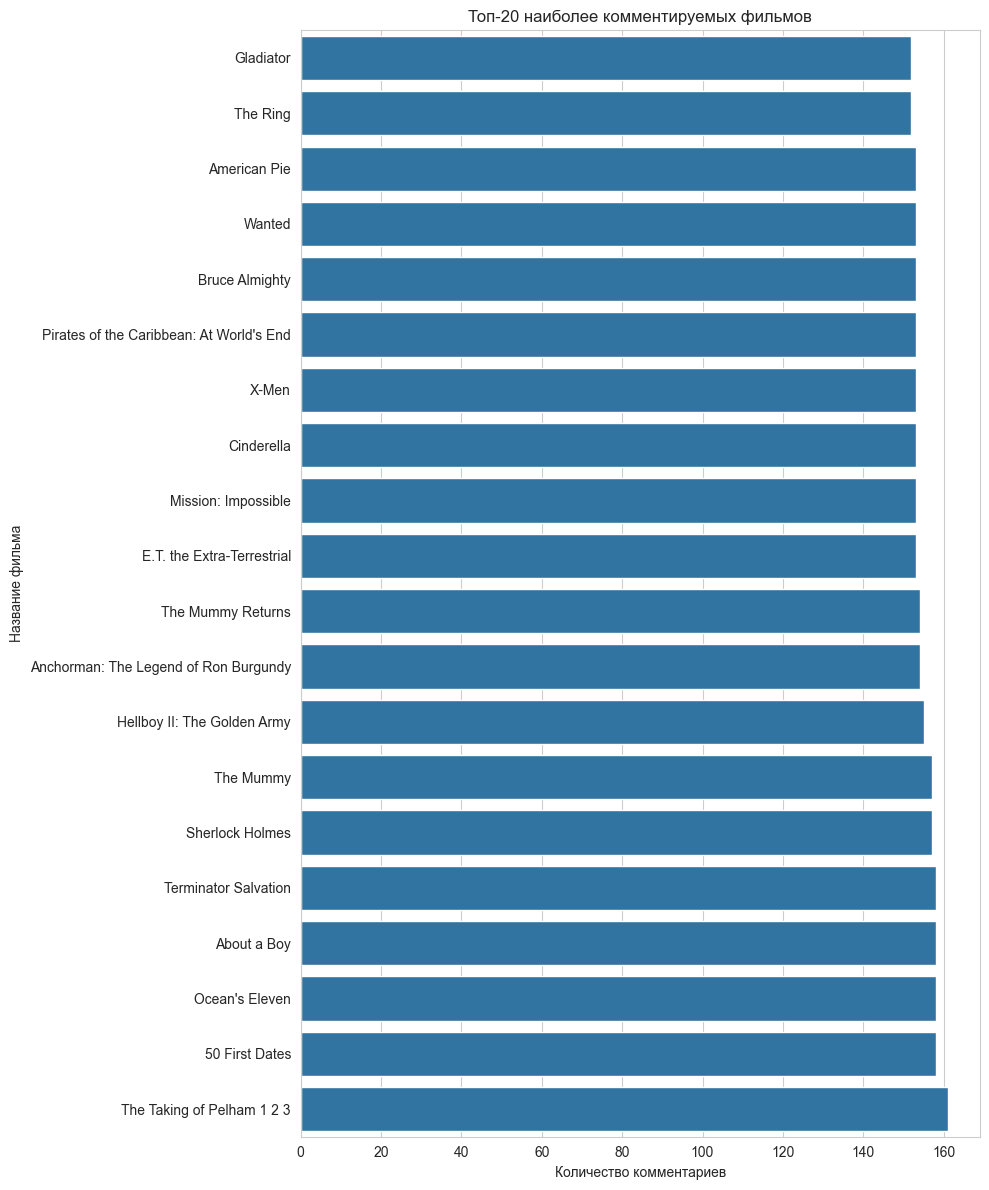

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

top_20 = result[:20]

titles = [doc["title"] for doc in top_20]
counts = [doc["count"] for doc in top_20]

df_plot = pd.DataFrame({
    "title": titles,
    "count": counts
})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 12))

sns.barplot(data=df_plot, y="title", x="count")
plt.xlabel("Количество комментариев")
plt.ylabel("Название фильма")
plt.title("Топ-20 наиболее комментируемых фильмов")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
